In [1]:
!pip install tensorflow-privacy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler


#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load and Preprocess Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/RT_IOT2022.csv', index_col = 0)

In [ ]:
# Multiclass problem
target_column = 'Attack_type'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

In [ ]:
data[target_column].value_counts()

In [ ]:
# Lets keet top 3 groups and implement imbalancing
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DOS_SYN_Hping','Thing_Speak','ARP_poisioning'])]

In [ ]:
# Add Upsampling
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

In [ ]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

In [ ]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

## Hypertune

In [ ]:
# !pip install keras-tuner --upgrade --q

In [ ]:
# import keras_tuner as kt

In [ ]:
# Build hypertunable model (adjust number of nodes, number of layers, learning rate, optimizer and dropout)
# def build_model(hp):
#     model = Sequential()
#     nodes = hp.Int('units_1', min_value=32, max_value=512, step=32)
#     model.add(Dense(units=nodes,
#                     activation='relu', input_shape=(len(categorical_columns),)))
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

#     for i in range(hp.Int('num_layers', 1, 5)):
#         model.add(Dense(units=nodes,
#                         activation='relu'))
#         model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

#     model.add(Dense(num_classes, activation='softmax'))

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

#     if hp_optimizer == 'adam':
#         optimizer = Adam(learning_rate=hp_learning_rate)
#     else:
#         optimizer = SGD(learning_rate=hp_learning_rate)

#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model

In [ ]:
#tuner = kt.RandomSearch(build_model,
                       # objective='val_loss',
                       # max_trials=100) # Change max trials to 100 for the full experiment

#tuner.search(X_train_scaled[categorical_columns], y_train, epochs=50, validation_data=(X_valid_scaled[categorical_columns] , y_valid)) # Change Epochs as well
#best_model = tuner.get_best_models()[0]

In [ ]:
# SAVE THIS
#best_model.summary()
#print(best_model.summary())

## Default MLP Model

In [ ]:
mlp_model = Sequential()
input_shape = (len(categorical_columns),)
mlp_model.add(Dense(units=512, activation='relu', input_shape=input_shape))
mlp_model.add(Dropout(rate=0.25))
mlp_model.add(Dense(units=512, activation='relu'))
mlp_model.add(Dropout(rate=0.4))
mlp_model.add(Dense(units=512, activation='relu'))
mlp_model.add(Dropout(rate=0.45))
mlp_model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
mlp_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#merge data and average accuracy and loss for all 6 fold

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

#training should be better than validation


#After fine tune train with train and validation set

#test on test dataset print out accuracy loss validation loss

# each fold score to print accuracy----done

# plot loss chart epoch accuracy draw graph(loss with and withought in one chart in graph)

#concatenate all training and validation set data cross validation



for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the current fold
    model_history = mlp_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=128, validation_data=(X_val_fold, y_val_fold))

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit full model
model_history = mlp_model.fit(X_train_scaled[categorical_columns], y_train, epochs=30, batch_size=128, validation_split = 0.2)

# Predict on the test data
y_test_pred_mlp = mlp_model.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred_mlp, axis=1)

Epoch 1/30
1387/1387 [==============================] - 32s 22ms/step - loss: 0.2040 - accuracy: 0.9316 - val_loss: 0.0591 - val_accuracy: 0.9818
Epoch 2/30
1387/1387 [==============================] - 30s 22ms/step - loss: 0.0660 - accuracy: 0.9783 - val_loss: 0.0382 - val_accuracy: 0.9830
Epoch 3/30
1387/1387 [==============================] - 33s 24ms/step - loss: 0.0476 - accuracy: 0.9835 - val_loss: 0.0293 - val_accuracy: 0.9882
Epoch 4/30
1387/1387 [==============================] - 29s 21ms/step - loss: 0.0376 - accuracy: 0.9868 - val_loss: 0.0242 - val_accuracy: 0.9910
Epoch 5/30
1387/1387 [==============================] - 31s 22ms/step - loss: 0.0325 - accuracy: 0.9886 - val_loss: 0.0242 - val_accuracy: 0.9910
Epoch 6/30
1387/1387 [==============================] - 29s 21ms/step - loss: 0.0293 - accuracy: 0.9895 - val_loss: 0.0211 - val_accuracy: 0.9915
Epoch 7/30
1387/1387 [==============================] - 31s 22ms/step - loss: 0.0274 - accuracy: 0.9902 - val_loss: 0.0205 -

In [ ]:
print(cv_results )

[(0.011935894377529621, 0.9955770969390869), (0.00932716578245163, 0.9959996342658997), (0.007816266268491745, 0.9970138072967529), (0.00844235997647047, 0.9969574809074402), (0.006346596870571375, 0.997689962387085), (0.006273550912737846, 0.9978026151657104)]


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.008356972364708781
Average cross-validation accuracy: 0.9968400994936625
MLP Model:
Accuracy =  0.9973589689414748
Precision = 0.9973583492688345
Recall = 0.9973747829198669
F1 Score =  0.9973654137215622


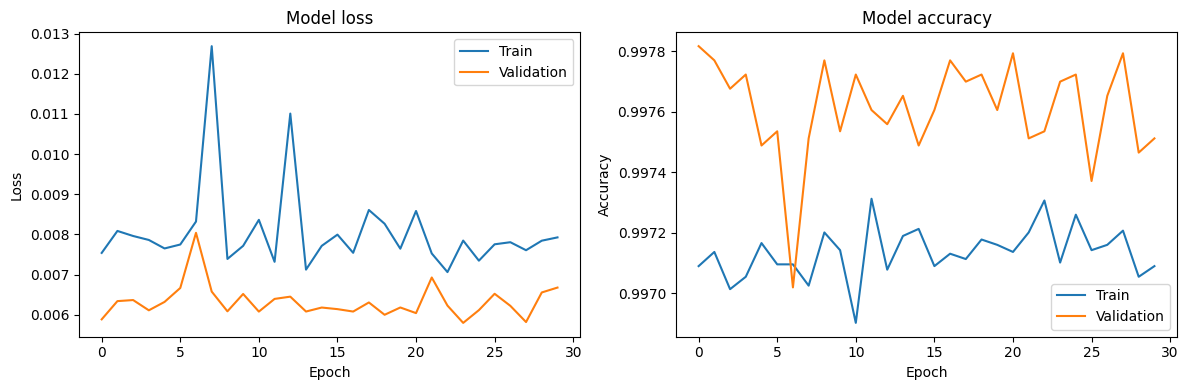

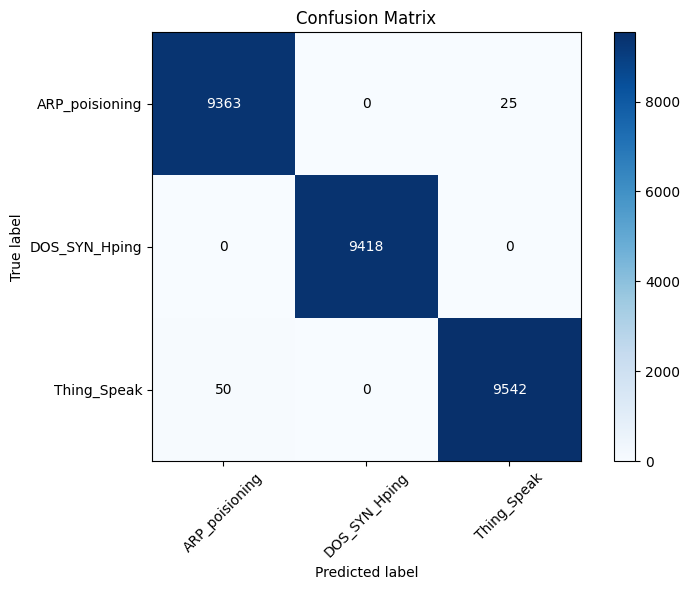

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (Not possible for Multiclass Classification, it is designed for Binary Class only)
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_mlp)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

## Privacy

In [ ]:
# Define your MLP model
mlp_model_privacy = Sequential()
mlp_model_privacy.add(Dense(units=512, activation='relu',input_shape=(len(categorical_columns),)))
mlp_model_privacy.add(Dropout(rate=0.25))
mlp_model_privacy.add(Dense(units=512, activation='relu'))
mlp_model_privacy.add(Dropout(rate=0.4))
mlp_model_privacy.add(Dense(units=512, activation='relu'))
mlp_model_privacy.add(Dropout(rate=0.45))
mlp_model_privacy.add(Dense(num_classes, activation='softmax'))


# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.003
)

# y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_valid2 = tf.keras.utils.to_categorical(y_valid, num_classes=2)

# Compile the model with the DP optimizer and loss function
mlp_model_privacy.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with differential privacy

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = [] #last iteration has full dataset

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Reshape
    # y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
    # y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

    # Train the model with DP for this fold
    model_history_privacy = mlp_model_privacy.fit(X_train_fold, y_train_fold,
              epochs=30,
              validation_data=(X_val_fold, y_val_fold),
              batch_size=batch_size // num_microbatches)

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model_privacy.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit full data
model_history_privacy = mlp_model_privacy.fit(X_train_scaled[categorical_columns], y_train,
              epochs=30,
              validation_split = 0.2,
              batch_size=batch_size // num_microbatches)

Epoch 1/30
11093/11093 [==============================] - 222s 20ms/step - loss: 158.9904 - accuracy: 0.5384 - val_loss: 71.3426 - val_accuracy: 0.8052
Epoch 2/30
11093/11093 [==============================] - 225s 20ms/step - loss: 866.5486 - accuracy: 0.6300 - val_loss: 345.2329 - val_accuracy: 0.7978
Epoch 3/30
11093/11093 [==============================] - 221s 20ms/step - loss: 2120.9509 - accuracy: 0.6592 - val_loss: 749.3248 - val_accuracy: 0.8396
Epoch 4/30
11093/11093 [==============================] - 226s 20ms/step - loss: 3841.0393 - accuracy: 0.6561 - val_loss: 787.2242 - val_accuracy: 0.8776
Epoch 5/30
11093/11093 [==============================] - 220s 20ms/step - loss: 5929.9712 - accuracy: 0.6750 - val_loss: 1172.6884 - val_accuracy: 0.8768
Epoch 6/30
11093/11093 [==============================] - 221s 20ms/step - loss: 7838.0605 - accuracy: 0.6907 - val_loss: 1615.8917 - val_accuracy: 0.8940
Epoch 7/30
11093/11093 [==============================] - 223s 20ms/step - lo

In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

888/888 [==============================] - 2s 3ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 245184.0654296875
Average cross-validation accuracy: 0.9194532831509908
MLP Model:
Accuracy =  0.9384815832100852
Precision = 0.9385046852967821
Recall = 0.9386599002695873
F1 Score =  0.9385701441450035


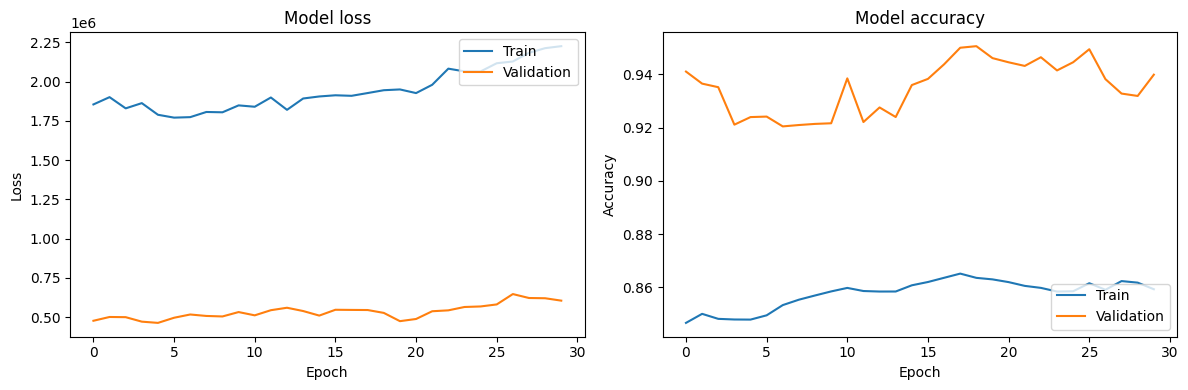

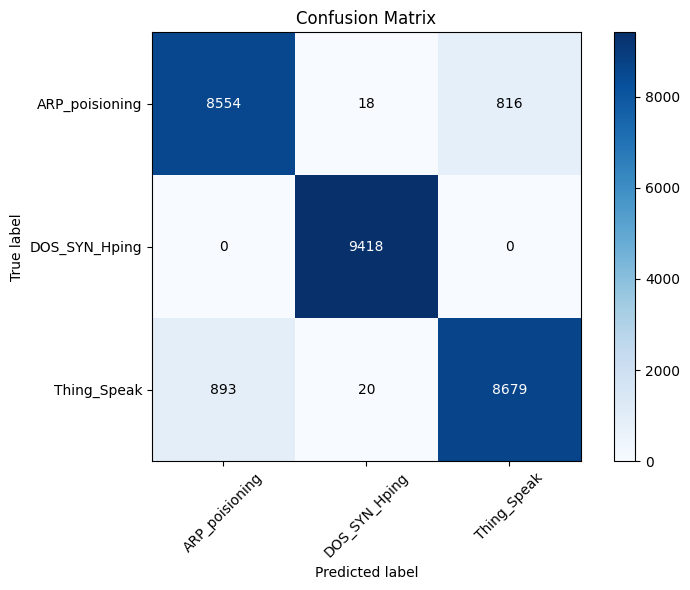

In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [ ]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 212982 examples with 16 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.466

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.997359,0.938482
1,Precision,0.997358,0.938505
2,Recall,0.997375,0.938660
3,F1 Score,0.997365,0.938570


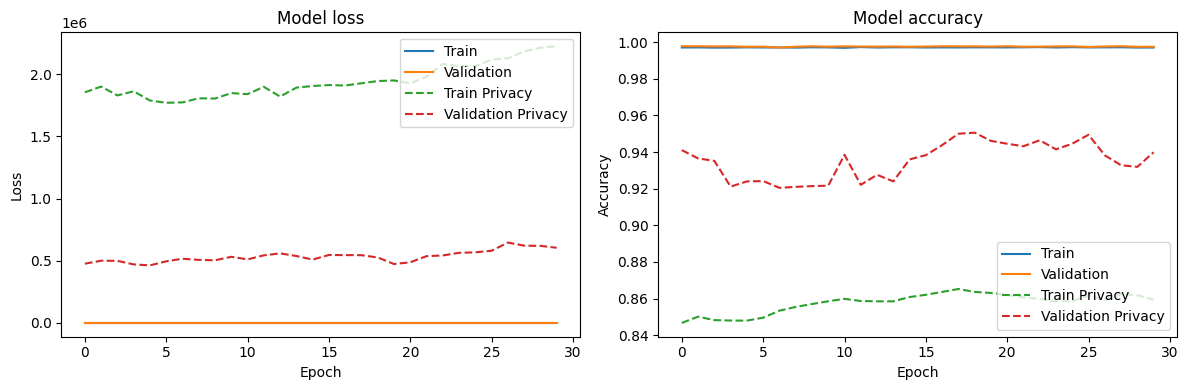

In [ ]:
plot_loss(model_history, model_history_privacy)